# Causal Inference in Decision Intelligence – Part 19: Building a Holistic Hierarchical Model

Link to the article:  [Building a Holistic Hierarchical Model](https://www.linkedin.com/pulse/causal-inference-decision-intelligence-part-19-model-eugene-zinoviev-wc4oc)

## Import libraries

In [ ]:
# Check if dowhy is installed, and install it if not
try:
    import dowhy
except ImportError:
    import subprocess
    import sys
    print("Installing dowhy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "dowhy"])
    import dowhy

In [1]:
from collections import OrderedDict

import numpy as np
import pandas as pd
import networkx as nx

import dowhy.gcm as gcm
from dowhy.utils import plot

from dowhy import CausalModel

from scipy import linalg 
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

pd.options.display.float_format='{:,.2f}'.format

## Create the true Directed Acyclic Graph (DAG)

In [3]:
# Create the true DAG
G = nx.DiGraph([('Macro', 'Sales'), ('Macro', 'Price'), ('Macro', 'Marketing'), 
                ('Income', 'Sales'), ('Price', 'Sales'), ('Marketing', 'Visits'), 
                ('Visits', 'Sales'), ('Sales', 'Revenue'), ('Price', 'Revenue'),
                ('Sales', 'Sales_costs'), ('Marketing', 'Profit'), 
                ('Sales_costs', 'Profit'), ('Revenue', 'Profit')])
# plot(G)

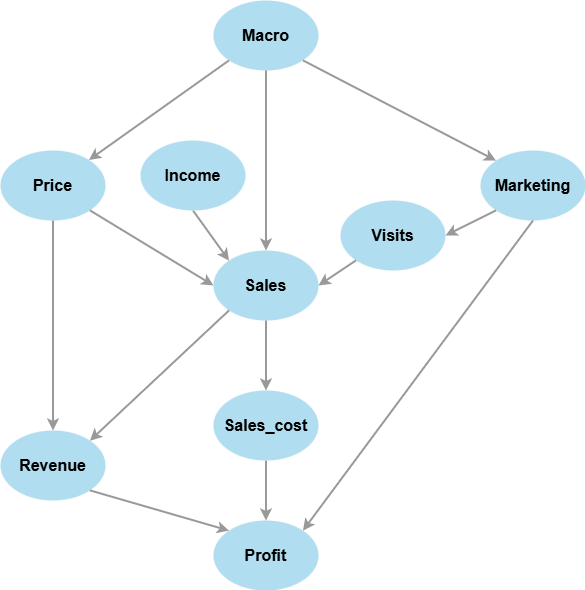

## Generate the data

In [5]:

np.random.seed(3)

# Generate customers' Ids 
Id = pd.Series(range(1,1001))

# Generate Income variable 
#Income = np.random.choice(["Low", "Medium", "High"], size=1000, p=[0.5, 0.35, 0.15])
Income = np.random.choice([1, 2, 3], size=1000, p=[0.5, 0.35, 0.15])


data = pd.DataFrame({"Id": Id, "Income": Income})

# Generate dates 
Year = pd.Series(range(2020,2024))

# Create the product of Ids and Years
year = pd.DataFrame({'Year': Year})
data = year.merge(data, how='cross')

# Generate Macro variable 
data["Macro"] = np.where(((data.Year==2022) | (data.Year==2020)), 1, 0)

# Create Price variable 
data['Price'] = 10 + 2 * data.Macro + np.random.normal(loc=0, scale=0.5, size=4000) 

# Create other variables 
data['Marketing'] = 80 - 10 * data.Macro + np.random.normal(loc=2, scale=1, size=4000) 
data['Visits'] = 0.1 * data.Marketing + np.random.normal(loc=0, scale=0.5, size=4000) 

data['Sales'] = 80 + 28 * data.Macro + 14 * data.Income - 7 * data.Price + 4 * data.Visits + np.random.normal(loc=0, scale=5, size=4000)


In [6]:
# Add Costs, Revenue and Profit variables
np.random.seed(3)

data['Sales_costs'] = 2 * data['Sales']
data['Revenue'] = data['Price'] * data['Sales']
data['Profit'] = data['Revenue'] - data['Sales_costs'] - data['Marketing']
data

,Year,Id,Income,Macro,Price,Marketing,Visits,Sales,Sales_costs,Revenue,Profit
0,2020,1,2,1,11.53,72.09,7.08,76.55,153.11,882.95,657.74
1,2020,2,2,1,11.38,72.77,7.55,81.91,163.81,932.09,695.51
2,2020,3,1,1,12.33,71.59,7.17,63.22,126.45,779.49,581.45
3,2020,4,2,1,11.08,70.46,7.73,88.22,176.44,977.82,730.91
4,2020,5,3,1,12.48,72.89,7.63,95.30,190.61,"1,189.56",926.06
...,...,...,...,...,...,...,...,...,...,...,...
3995,2023,996,1,0,9.26,83.33,7.72,65.57,131.14,607.23,392.76
3996,2023,997,2,0,9.67,80.50,7.40,75.23,150.45,727.54,496.59
3997,2023,998,1,0,10.25,84.99,8.96,54.03,108.05,553.97,360.93
3998,2023,999,1,0,10.01,80.67,8.30,55.54,111.08,555.99,364.25


## Example

### Marketing Budget Model

In [7]:
# Estimate the causal effect of Macro on Marketing
model_mb = smf.ols('Marketing ~ Macro', data).fit()

model_mb.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,82.0004,0.022,3654.221,0.000,81.956,82.044
Macro,-10.0059,0.032,-315.296,0.000,-10.068,-9.944


### Marketing effect Model

In [9]:
# Estimate the causal effect of Marketing on Visits
model_me = smf.ols('Visits ~ Marketing', data).fit()

model_me.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1246,0.118,-1.060,0.289,-0.355,0.106
Marketing,0.1015,0.002,66.666,0.000,0.099,0.105


### Product Model

In [10]:
# Estimate the causal effect of Visits on Sales
model_p = smf.ols('Sales ~ Visits + Marketing', data).fit()

model_p.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,142.9969,2.867,49.869,0.000,137.375,148.619
Visits,4.7069,0.386,12.200,0.000,3.951,5.463
Marketing,-1.4037,0.054,-25.999,0.000,-1.510,-1.298


The coefficient of Visits is close to the true one (4.0).

The coefficient of Marketing does not have any meaning here. It just closes the backdoor path.

### Including all the covariates in Sales Model

In [13]:
# Estimate the causal effect of the variables on Sales
model_p = smf.ols('Sales ~ Visits + Macro + Price + C(Income)', data).fit()

model_p.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.4455,2.070,45.132,0.000,89.386,97.505
C(Income)[T.2],14.4075,0.174,82.632,0.000,14.066,14.749
C(Income)[T.3],28.3099,0.238,119.133,0.000,27.844,28.776
Visits,4.0742,0.158,25.706,0.000,3.764,4.385
Macro,28.0875,0.392,71.625,0.000,27.319,28.856
Price,-7.0261,0.160,-43.780,0.000,-7.341,-6.711


The coefficient of Visits is closer to the true one and the standard error is lower (a higher precision).

## Apply Graphical Causal Model (GCM) for causal tasks

### Build Graphical Causal Model

In [15]:
# Build Structural causal model on top of the causal graph
np.random.seed(3)
causal_model = gcm.StructuralCausalModel(G)

# Assign causal mechanisms to each node
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)

# Fit the graphical causal model
gcm.fit(causal_model, data)

Fitting causal mechanism of node Profit: 100%|███████████████████████████████████████████| 9/9 [00:03<00:00,  2.54it/s]


### Simulate the effect of Macro on Profit

In [19]:
# Estimate the average causal effect of Macro on Profit
np.random.seed(3)
ate = gcm.average_causal_effect(causal_model,
                         'Profit',
                         interventions_alternative={'Macro': lambda x: 1},
                         interventions_reference={'Macro': lambda x: 0},
                         num_samples_to_draw=10000)

print(f'Average Treatment Effect: {round(ate, 2)}')

Average Treatment Effect: 240.92


### Simulate the intrinsic effect of each variable on Profit

In [20]:
# Create a function to convert the strength to percentage
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}

In [25]:
# Quantify intrinsic causal inference
contributions = gcm.intrinsic_causal_influence(causal_model, 'Profit')
convert_to_percentage(contributions)

Evaluating set functions...: 100%|███████████████████████████████████████████████████| 145/145 [02:11<00:00,  1.10it/s]


{'Macro': 13826.563023617622,
 'Income': 7918.294125092998,
 'Price': 47.715731064671424,
 'Marketing': 11.47847476391906,
 'Visits': 296.1335497195666,
 'Sales': 1746.9388122160256,
 'Revenue': -0.15415962717659304,
 'Sales_costs': -0.20680313184575727,
 'Profit': -0.022066006372833725}

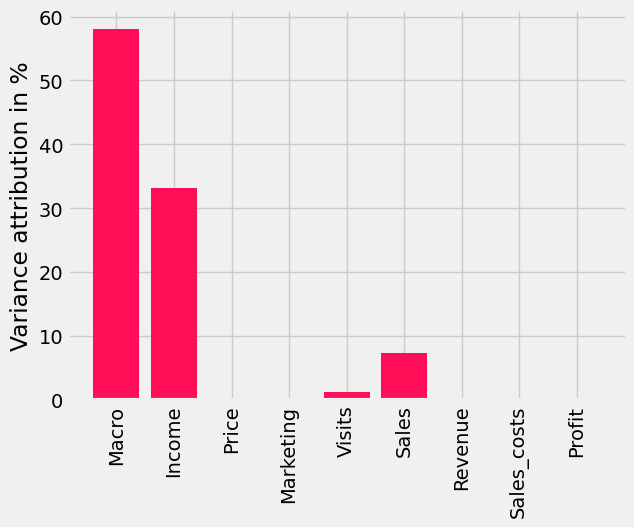

In [27]:
# Plot the percentage contribution of each variable
from dowhy.utils import bar_plot

bar_plot(convert_to_percentage(contributions), ylabel='Variance attribution in %')

If we use a simple model, Revenue will have the highest direct effect on Profit.
The holistic model includes the effects of other variables on Revenue and shows that Macro and Income explain 90% of the variation in Profit.